## Proyecto: ChatBot

### Participantes:

- Edwin Ramirez
- Tatiana Garcia
- Omar Alvarracin

### Contexto:

Un Chatbot por lo general usa un modelo de redes recurrentes (o sus análogos de LSTM o GRU) del tipo Seq-to-Seq para entrena un sistema automático que responda ciertas preguntas que se le hagan o sea capaz de responder e interactuar en conversaciones. En este sentido, es parecido a un modelo de traducción, con la diferencia que la salida no es el mismo texto en otro idioma, sino la respuesta natural para continuar en una conversación.

Para entrenar este modelo, es posible usar los datos de conversaciones de películas recopilada por Danescu et al. en 2011. Estos datos se conocen como “Cornell Movie – Dialogs Corpus”. Los pude encontrar en el siguiente link:
https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html

La idea es entrenar un modelo de Chatbot que sea capaz sea responder e interactuar en conversaciones.

### Dataset:
(https://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip)


 Librerias:

In [ ]:
# librerias inciales
import re  # Para trabajar con expresiones regulares (búsqueda y manipulación de texto)
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GRU

### Carga de datos

AL descomprimir el archivo zip, encotramos varios archivos, de acuerdo al archivo README: corresponde a un corpus que contiene una colección rica en metadatos de conversaciones ficticias extraídas de guiones de películas en bruto:

- 220,579 intercambios conversacionales entre 10,292 pares de personajes de películas
- involucra a 9,035 personajes de 617 películas
- en total 304,713 expresiones
- metadatos de películas incluidos:
	- géneros
	- año de estreno
	- calificación IMDB
	- número de votos IMDB
	- calificación IMDB
- metadatos de personajes incluidos:
	- género (para 3,774 personajes)
	- posición en los créditos de la película (para 3,321 personajes)


En cuanto a los archivos que hacen parte del corpus encotramos:
- movie_titles_metadata.txt
- movie_characters_metadata.txt
- movie_lines.txt
- movie_conversations.txt
- raw_script_urls.txt

Para el contexto del proyecto y luego de revisar los archivos manualmente, se determino que los archivos a usar son (movie_lines.txt y movie_conversations.txt) por que son los que contiene los dialogos de cada pelicula y tiene el contesto de pregunta respuestas en algunos casos; lo cual puede ser util para la generacion de la herramienta.

 Carga de datos:

Cargamos el archivo movie_lines.txt

In [ ]:
lineas = open(r'C:\Users\Usuario\Downloads\glove.6B\movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')

In [ ]:
lineas[:10]

['L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!',
 'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!',
 'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.',
 'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?',
 "L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.",
 'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow',
 "L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.",
 'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No',
 'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?',
 'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?']

In [ ]:
#tamaño de la lista
len(lineas)

304714

Cargamos el archivo movie_conversations.txt

In [ ]:
conver_lineas = open(r'C:\Users\Usuario\Downloads\glove.6B\movie_conversations.txt',encoding='utf-8', errors='ignore').read().split('\n')

In [ ]:
conver_lineas[:10]

["u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L205', 'L206']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L271', 'L272', 'L273', 'L274', 'L275']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L276', 'L277']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L280', 'L281']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L363', 'L364']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L365', 'L366']"]

In [ ]:
#tamaño de conver_lineas
print("Número de líneas en movie_conversations.txt:", len(conver_lineas))

Número de líneas en movie_conversations.txt: 83098


Podemos ver que existe una relacion entre los archivos, En el archivo de conversacion indica con un codigo cada linea y las agrupa para identificar una conversacion.

Deacuerdo al archivo README, indica que el separador usado entre valores es '+++$+++'.

In [ ]:
# Crea una lista de todos los ids de líneas de conversaciones.

conversaciones = [ ]
for k in conver_lineas:
    conversaciones.append(k.split(' +++$+++ ')[-1][1:-1].replace("'"," ").replace(",","").split())

# Imprime los primeros 10 elementeos
conversaciones[:10]

[['L194', 'L195', 'L196', 'L197'],
 ['L198', 'L199'],
 ['L200', 'L201', 'L202', 'L203'],
 ['L204', 'L205', 'L206'],
 ['L207', 'L208'],
 ['L271', 'L272', 'L273', 'L274', 'L275'],
 ['L276', 'L277'],
 ['L280', 'L281'],
 ['L363', 'L364'],
 ['L365', 'L366']]

In [ ]:
# Genramos un diccionario para relacionar el id de la linea con el texto
dialogos = {}
for linea in lineas:
    dialogos[linea.split(' +++$+++ ')[0]] = linea.split(' +++$+++ ')[-1]

# Imprime los primeros 20 elementos
count = 0
for key, value in dialogos.items():
    print(f"'{key}': '{value}'")
    count += 1
    if count == 20:
        break

'L1045': 'They do not!'
'L1044': 'They do to!'
'L985': 'I hope so.'
'L984': 'She okay?'
'L925': 'Let's go.'
'L924': 'Wow'
'L872': 'Okay -- you're gonna need to learn how to lie.'
'L871': 'No'
'L870': 'I'm kidding.  You know how sometimes you just become this "persona"?  And you don't know how to quit?'
'L869': 'Like my fear of wearing pastels?'
'L868': 'The "real you".'
'L867': 'What good stuff?'
'L866': 'I figured you'd get to the good stuff eventually.'
'L865': 'Thank God!  If I had to hear one more story about your coiffure...'
'L864': 'Me.  This endless ...blonde babble. I'm like, boring myself.'
'L863': 'What crap?'
'L862': 'do you listen to this crap?'
'L861': 'No...'
'L860': 'Then Guillermo says, "If you go any lighter, you're gonna look like an extra on 90210."'
'L699': 'You always been this selfish?'


In [ ]:
del(lineas, conver_lineas, k, linea)

Se debe clasificar los dialogos en preguntas que seria las entradas y respuesta que serian las salidas o respuestas deseadas.

In [ ]:
# Se clasifican los dialogos:
preguntas = []
respuestas = []

for conv in conversaciones:
    for i in range(len(conv)-1):
        preguntas.append(dialogos[conv[i]])
        respuestas.append(dialogos[conv[i+1]])

In [ ]:
respuestas[10]

"Right.  See?  You're ready for the quiz."

- Borramos las varaibles que ya no vamos a usar.

In [ ]:
del (dialogos, conversaciones, conv, i)

- Filtramos las preguntas y respuestas para que no tengan mas de 13 caracteres.


In [ ]:
orden_preguntas = []
orden_respuestas = []

for i in range(len(preguntas)):
    if len(preguntas[i]) < 13:
        orden_preguntas.append(preguntas[i])
        orden_respuestas.append(respuestas[i])

- Funsion para limpiarel texto eliminando caracteres innecesarios y modificando el formato de las palabras.

In [ ]:
def limpia_texto(txt):
    txt = txt.lower()
    txt = re.sub(r"i'm", "i am", txt)
    txt = re.sub(r"he's", "he is", txt)
    txt = re.sub(r"she's", "she is", txt)
    txt = re.sub(r"it's", "it is", txt)
    txt = re.sub(r"that's", "that is", txt)
    txt = re.sub(r"what's", "what is", txt)
    txt = re.sub(r"where's", "where is", txt)
    txt = re.sub(r"how's", "how is", txt)
    txt = re.sub(r"\'ll", " will", txt)
    txt = re.sub(r"\'ve", " have", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"\'d", " would", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"won't", "will not", txt)
    txt = re.sub(r"can't", "cannot", txt)
    txt = re.sub(r"n't", " not", txt)
    txt = re.sub(r"n'", "ng", txt)
    txt = re.sub(r"'bout", "about", txt)
    txt = re.sub(r"'til", "until", txt)
    txt = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", txt)
    return txt

- Limpanos las preguntas y las respuestas

In [ ]:
preguntas_limpias = []
for linea_pregunta in orden_preguntas:
    preguntas_limpias.append(limpia_texto(linea_pregunta))

respuestas_limpias = []
for linea_respuesta in orden_respuestas:
    respuestas_limpias.append(limpia_texto(linea_respuesta))

In [ ]:
preguntas_limpias[:2]

['cameron', 'why']

In [ ]:
respuestas_limpias[:2]

['the thing is cameron  i am at the mercy of a particularly hideous breed of loser  my sister  i cannot date until she does',
 'unsolved mystery  she used to be really popular when she started high school then it was just like she got sick of it or something']

- Limitamos las respuestas a 13 palabras para mantener consistencia en el tamaño de las secuencias

In [ ]:
for i in range(len(respuestas_limpias)):
    respuestas_limpias[i] = ' '.join(respuestas_limpias[i].split()[:13])

- Borramos las varaibles que ya no vamos a usar.

In [ ]:
del(respuestas, preguntas, linea_respuesta, linea_pregunta,orden_respuestas, orden_preguntas)

- Limitamos el tamaño del dataset a 15000 preguntas y respuestas para reducir el tiempo de entrenamiento

In [ ]:
# trimming
respuestas_limpias=respuestas_limpias[:30000]
preguntas_limpias=preguntas_limpias[:30000]

- Crear un diccionario para la frecuencia del vocabulario.

In [ ]:
palabra_cont = {}
for linea in preguntas_limpias:
    for palabra in linea.split():
        if palabra not in palabra_cont:
            palabra_cont[palabra] = 1
        else:
            palabra_cont[palabra] += 1

for linea in respuestas_limpias:
    for palabra in linea.split():
        if palabra not in palabra_cont:
            palabra_cont[palabra] = 1
        else:
            palabra_cont[palabra] += 1

del(linea, palabra)

In [ ]:
palabra_cont

{'cameron': 12,
 'why': 1518,
 'there': 788,
 'sure': 566,
 'have': 2392,
 'hi': 555,
 'i': 11871,
 'was': 1499,
 'well': 1114,
 'no': 3194,
 'but': 1121,
 'what': 5917,
 'crap': 14,
 'wow': 55,
 'she': 1021,
 'okay': 781,
 'they': 1050,
 'do': 3696,
 'to': 5119,
 'who': 1099,
 'great': 221,
 'it': 5838,
 'is': 6997,
 'more': 245,
 'queen': 11,
 'harry': 60,
 'neat': 6,
 'joey': 22,
 'that': 3316,
 'not': 5189,
 'let': 255,
 'go': 987,
 'daddy': 68,
 'never': 401,
 'thirtytwo': 2,
 'get': 1000,
 'out': 893,
 'he': 2201,
 'pretty': 126,
 'away': 167,
 'yeah': 2033,
 'am': 2406,
 'on': 1387,
 'forget': 99,
 'hey': 435,
 "who's": 180,
 'this': 1770,
 'you': 12478,
 'did': 1282,
 'excuse': 146,
 'me': 2807,
 'told': 243,
 'dorsey': 2,
 'hate': 71,
 'him': 824,
 'busy': 24,
 'maybe': 302,
 'bianca': 5,
 'wholesome': 1,
 'unwelcome': 3,
 'good': 783,
 'call': 259,
 'yes': 2646,
 'how': 1235,
 'fallacy': 1,
 'the': 6488,
 'duck': 6,
 'hearsay': 2,
 'peas': 2,
 'tell': 579,
 'oh': 1318,
 'huh'

- Eliminamos palabras raras del vocabulario.
- Su objetivo es reemplazar menos del 5% de las palabras con `<UNK>`

In [ ]:
umbral = 5
vocabulario = {}
palabra_num = 0
for palabra, cont in palabra_cont.items():
    if cont >= umbral:
        vocabulario[palabra] = palabra_num
        palabra_num += 1

print("Tamaño del vocavulario total:", len(vocabulario))
print("Tamaño del vocabulario que usaremos:", palabra_num)

Tamaño del vocavulario total: 3164
Tamaño del vocabulario que usaremos: 3164


- Borramos las varaibles que ya no vamos a usar.

In [ ]:
del(palabra_cont,palabra,cont,umbral,palabra_num)

- Agregamos tokens especiales al vocabulario (`<PAD>`, `<EOS>`, `<OUT>`, `<SOS>`)
- Asignamos valores numéricos a los tokens
- Creamos un diccionario inverso para mapear números a palabras
- Hacemos un caso especial para 'cameron' asignándole el mismo valor que `<PAD>`

Los tokens especiales son:
- `<PAD>`: Se usa para rellenar secuencias y hacer que todas tengan la misma longitud
- `<EOS>`: End of Sequence - Marca el final de una secuencia
- `<OUT>`: Out of Vocabulary - Para palabras que no están en el vocabulario
- `<SOS>`: Start of Sequence - Marca el inicio de una secuencia



In [ ]:
for i in range(len(respuestas_limpias)):
    respuestas_limpias[i] = '<SOS> ' + respuestas_limpias[i] + ' <EOS>'

tokens = ['<PAD>', '<EOS>', '<OUT>', '<SOS>']
x = len(vocabulario)

for token in tokens:
    vocabulario[token] = x
    x += 1

vocabulario['cameron'] = vocabulario['<PAD>']
vocabulario['<PAD>'] = 0

del(x,token, tokens)

# Inverse Answers Dictionary
inv_vocab = {w:v for v, w in vocabulario.items()}
del(i)

Codificación de las preguntas y respuestas:
- Convertimos cada palabra de las preguntas o respuestas a su valor numérico correspondiente del vocabulario
- Si una palabra no está en el vocabulario, se reemplaza con el token `<OUT>`
- El resultado es una lista de listas donde cada sublista contiene los valores numéricos de las palabras

In [ ]:
entrada_codificador = []
for linea in preguntas_limpias:
    lista = []
    for palabra in linea.split():
        if palabra not in vocabulario:
            lista.append(vocabulario['<OUT>'])
        else:
            lista.append(vocabulario[palabra])

    entrada_codificador.append(lista)

In [ ]:
entrada_codificador[:2]

[[3164], [1]]

In [ ]:
entrada_decodificador = []
for linea in respuestas_limpias:
    lista = []
    for palabra in linea.split():
        if palabra not in vocabulario:
            lista.append(vocabulario['<OUT>'])
        else:
            lista.append(vocabulario[palabra])
    entrada_decodificador.append(lista)

In [ ]:
entrada_decodificador[:2]

[[3167, 60, 527, 22, 3164, 6, 40, 280, 60, 3166, 68, 86, 2279, 3166, 3165],
 [3167,
  3166,
  944,
  14,
  1052,
  18,
  225,
  123,
  2280,
  70,
  14,
  2281,
  634,
  1117,
  3165]]

- Borramos las varaibles que ya no vamos a usar.

In [ ]:
del(respuestas_limpias, preguntas_limpias, linea, lista, palabra)

- Padding de las entradas para el modelo LSTM

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

- Ajuste de las secuencias de entrada y salida para el modelo LSTM

In [ ]:
# Padding de las preguntas  (entrada del codificador)
entrada_codificador = pad_sequences(entrada_codificador, 13, padding='post', truncating='post')

# Padding de las respuestas (entrada del decodificador)
entrada_decodificador = pad_sequences(entrada_decodificador, 13, padding='post', truncating='post')

- Generar la salida final del decodificador (shift a la izquierda)

In [ ]:
salida_final_decodificador = []
for seq in entrada_decodificador:
    salida_final_decodificador.append(seq[1:])
salida_final_decodificador = pad_sequences(salida_final_decodificador, 13, padding='post', truncating='post')
del(seq)

- Codificación one-hot de la salida final del decodificador

In [ ]:
salida_final_decodificador = to_categorical(salida_final_decodificador, len(vocabulario))
print(salida_final_decodificador.shape)

(30000, 13, 3168)


### Creación de un modelo de codificación mediante GRU

In [ ]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Tamaño del vocabulario y capa de embedding
TAM_VOCAB = len(vocabulario)
embedding = Embedding(TAM_VOCAB+1, output_dim=32,
                     input_length=13,
                     trainable=True
                    )

c:\Users\Usuario\Documents\MAESTRÍA\Semestre 2\Deep learning\condapython3_9\.conda\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

#### Calibración hiper parámetros GRU

In [ ]:
TAM_VOCAB = len(vocabulario)
class ChatbotHyperModel(HyperModel):
    def __init__(self, vocab_size, input_length):
        self.vocab_size = vocab_size
        self.input_length = input_length

    def build(self, hp):
        # Inputs
        entrada_cod = Input(shape=(self.input_length,))
        entrada_dec = Input(shape=(self.input_length,))

        # Hiperparámetros
        embed_dim = hp.Choice('embedding_dim', [32, 50, 64, 128])
        lstm_units = hp.Choice('gru_units', [64, 128, 200, 500])
        learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

        # Embedding
        embedding_cod = Embedding(input_dim=self.vocab_size+1,
                              output_dim=embed_dim,
                              input_length=self.input_length,
                              trainable=True)

        embedding_dec = Embedding(input_dim=self.vocab_size+1,
                                output_dim=embed_dim,
                                input_length=self.input_length,
                                trainable=True)

        cod_embed = embedding_cod(entrada_cod)


        cod_GRU = GRU(lstm_units, return_sequences=True, return_state=True)
        cod_salida, h = cod_GRU(cod_embed)
        estados_cod = [h]

        dec_embed = embedding_dec(entrada_dec)
        dec_GRU = GRU(lstm_units, return_sequences=True, return_state=True)
        dec_salida, _ = dec_GRU(dec_embed, initial_state=estados_cod)

        densa = Dense(self.vocab_size, activation='softmax')
        salida_densa = densa(dec_salida)

        modelo = Model([entrada_cod, entrada_dec], salida_densa)

        modelo.compile(
            loss='categorical_crossentropy',
            optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate),
            metrics=['acc']
        )

        return modelo


# Define el modelo hypermodel
hypermodel = ChatbotHyperModel(vocab_size=TAM_VOCAB, input_length=13)

# Inicializa el tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_acc',
    max_trials=10,  # número de combinaciones a probar
    executions_per_trial=1,
    directory=r'C:/Users/Usuario/Desktop/keras_tuner_dir', # Cambia esto a tu directorio
    project_name='chatbot1_seq2seqgru'
)

early_stop = EarlyStopping(monitor='val_loss', patience=20,       # N° de épocas sin mejora antes de detener
    restore_best_weights=True)
# Inicia la búsqueda
tuner.search(
    [entrada_codificador, entrada_decodificador],
    salida_final_decodificador,
    epochs=60,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

best_model_GRU = tuner.get_best_models(num_models=1)[0]
best_hps_GRU = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Mejores hiperparámetros encontrados para GRU:")
print(f"Embedding dim: {best_hps_GRU.get('embedding_dim')}")
print(f"GRU units: {best_hps_GRU.get('lstm_units')}")
print(f"Learning rate: {best_hps_GRU.get('learning_rate')}")


Trial 10 Complete [00h 30m 14s]
val_acc: 0.5280256867408752

Best val_acc So Far: 0.5295384526252747
Total elapsed time: 22h 10m 46s
Mejores hiperparámetros encontrados para GRU:
Embedding dim: 128
GRU units: 200
Learning rate: 0.001


c:\Users\Usuario\Documents\MAESTRÍA\Semestre 2\Deep learning\condapython3_9\.conda\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
tuner.results_summary()

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Reconstruir el modelo manualmente:
modelGRU = hypermodel.build(best_hps)

Results summary
Results in C:/Users/Usuario/Desktop/keras_tuner_dir\chatbot1_seq2seqgru
Showing 10 best trials
Objective(name="val_acc", direction="max")

Trial 07 summary
Hyperparameters:
embedding_dim: 128
lstm_units: 200
learning_rate: 0.001
Score: 0.5295384526252747

Trial 02 summary
Hyperparameters:
embedding_dim: 128
lstm_units: 256
learning_rate: 0.0001
Score: 0.5282307863235474

Trial 09 summary
Hyperparameters:
embedding_dim: 32
lstm_units: 128
learning_rate: 0.001
Score: 0.5280256867408752

Trial 04 summary
Hyperparameters:
embedding_dim: 32
lstm_units: 256
learning_rate: 0.0001
Score: 0.5262179374694824

Trial 01 summary
Hyperparameters:
embedding_dim: 64
lstm_units: 64
learning_rate: 0.01
Score: 0.5255640745162964

Trial 00 summary
Hyperparameters:
embedding_dim: 50
lstm_units: 64
learning_rate: 0.01
Score: 0.5238204598426819

Trial 03 summary
Hyperparameters:
embedding_dim: 32
lstm_units: 64
learning_rate: 0.01
Score: 0.5232820510864258

Trial 05 summary
Hyperparameters:
e

c:\Users\Usuario\Documents\MAESTRÍA\Semestre 2\Deep learning\condapython3_9\.conda\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


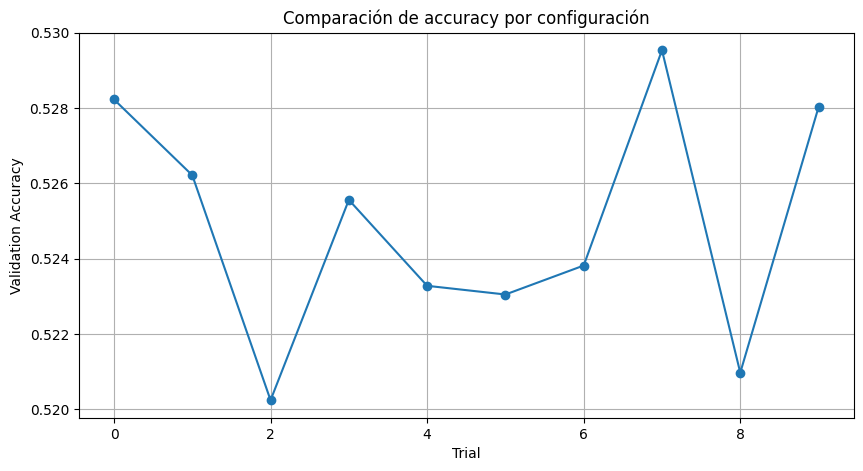

In [ ]:
# Obtener los trials correctamente desde el oracle
trialsGRU = list(tuner.oracle.trials.values())

# Extraer datos
val_accsGRU = [trial.score for trial in trialsGRU]
embedding_dimsGRU = [trial.hyperparameters.get('embedding_dim') for trial in trialsGRU]
lstm_unitsGRU = [trial.hyperparameters.get('lstm_units') for trial in trialsGRU]

# Crear gráfico
plt.figure(figsize=(10, 5))
plt.plot(val_accsGRU, marker='o')
plt.title('Comparación de accuracy por configuración')
plt.xlabel('Trial')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

  trial_id   val_acc  embedding_dim  lstm_units  learning_rate
7       07  0.529538            128         200         0.0010
0       02  0.528231            128         256         0.0001
9       09  0.528026             32         128         0.0010
1       04  0.526218             32         256         0.0001
3       01  0.525564             64          64         0.0100
6       00  0.523820             50          64         0.0100
4       03  0.523282             32          64         0.0100
5       05  0.523051             50         128         0.0001
8       08  0.520974             32         128         0.0001
2       06  0.520244             64         200         0.0100


Text(0.5, 0, 'Embedding Dimension')

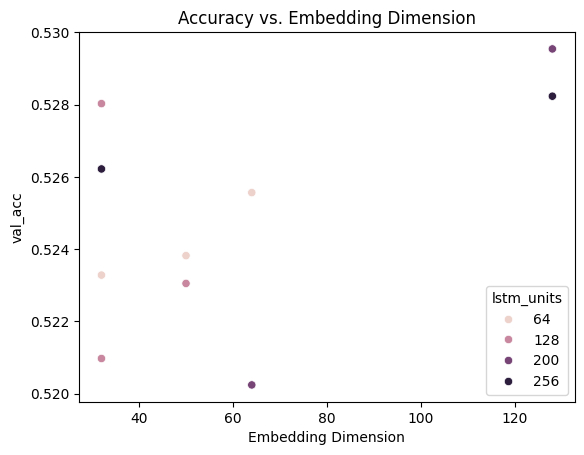

In [ ]:
# Guardar resultados en un dataframe

df = pd.DataFrame([
    {
        'trial_id': trial.trial_id,
        'val_acc': trial.score,
        'embedding_dim': trial.hyperparameters.get('embedding_dim'),
        'lstm_units': trial.hyperparameters.get('lstm_units'),
        'learning_rate': trial.hyperparameters.get('learning_rate'),
    }
    for trial in trialsGRU
])

print(df.sort_values(by='val_acc', ascending=False))

# También puedes hacer gráficos de dispersión
import seaborn as sns
sns.scatterplot(data=df, x='embedding_dim', y='val_acc', hue='lstm_units')
plt.title('Accuracy vs. Embedding Dimension')
plt.xlabel('Embedding Dimension')

#### ENTRENAR MODELOS CON MEJORES HIPRPARÁMETROS PARA GRU ...

In [ ]:
# Definición de las capas de entrada
entrada_cod = Input(shape=(13, ))
entrada_dec = Input(shape=(13, ))

# Tamaño del vocabulario y capa de embedding
TAM_VOCAB = len(vocabulario)
embedding = Embedding(TAM_VOCAB+1, output_dim=128,
                     input_length=13,
                     trainable=True
                    )
# Codificador
cod_embed = embedding(entrada_cod)
cod_gru = GRU(200, return_sequences=True, return_state=True)
cod_salida, h = cod_gru(cod_embed)
estados_cod = [h]

# Decodificador
dec_embed = embedding(entrada_dec)
dec_gru = GRU(200, return_sequences=True, return_state=True)
dec_salida, _ = dec_gru(dec_embed, initial_state=estados_cod)

# Capa densa de salida
densa = Dense(TAM_VOCAB, activation='softmax')
salida_densa = densa(dec_salida)

# Definición del modelo
modelo = Model([entrada_cod, entrada_dec], salida_densa)

# Compilación
modelo.compile(loss='categorical_crossentropy',
              metrics=['acc'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


# Entrenamiento
early_stop = EarlyStopping(monitor='loss', patience=5,       # N° de épocas sin mejora antes de detener
    restore_best_weights=True)
modelo.fit([entrada_codificador, entrada_decodificador],
          salida_final_decodificador,
          epochs=60,
          batch_size=64,
          callbacks=[early_stop])


c:\Users\Usuario\Documents\MAESTRÍA\Semestre 2\Deep learning\condapython3_9\.conda\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 86s 171ms/step - acc: 0.4351 - loss: 3.9289
Epoch 2/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 170ms/step - acc: 0.5139 - loss: 2.8223
Epoch 3/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 171ms/step - acc: 0.5246 - loss: 2.6763
Epoch 4/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 181ms/step - acc: 0.5317 - loss: 2.5818
Epoch 5/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 177ms/step - acc: 0.5348 - loss: 2.5298
Epoch 6/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 177ms/step - acc: 0.5384 - loss: 2.4729
Epoch 7/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 176ms/step - acc: 0.5399 - loss: 2.4332
Epoch 8/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 178ms/step - acc: 0.5454 - loss: 2.3760
Epoch 9/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 87s 184ms/step - acc: 0.5440 - loss: 2.3538
Epoch 10/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 178ms/step - acc: 0.5485 - loss: 2.3120
Epoch 11/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 177ms/step - acc: 0.5506 - loss: 2.2682
Epoch 12/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 167ms/step - acc: 0.5536 - lo

In [ ]:
# Modelo codificador
#modelo_cod = Model([entrada_cod], estados_cod)

# Modelo decodificador
#estado_entrada_h = Input(shape=(200,))
#estado_entrada_c = Input(shape=(200,))

#estados_entrada_dec = [estado_entrada_h, estado_entrada_c]

#salidas_dec, estado_h, estado_c = dec_lstm(dec_embed,
#                                         initial_state=estados_entrada_dec)

#estados_dec = [estado_h, estado_c]

#modelo_dec = Model([entrada_dec] + estados_entrada_dec,
#                  [salidas_dec] + estados_dec)

#modelo_dec.compile(loss='categorical_crossentropy',
#                  metrics=['acc'],
#                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Modelo codificador
modelo_cod = Model([entrada_cod], estados_cod)

# Modelo decodificador GRU
estado_entrada_h = Input(shape=(200,))
dec_embed2 = embedding(entrada_dec)
salidas_dec, estado_h = dec_gru(dec_embed2, initial_state=[estado_entrada_h])
modelo_dec_gru = Model([entrada_dec, estado_entrada_h], [salidas_dec, estado_h])
modelo_dec_gru.compile(loss='categorical_crossentropy',
                       metrics=['acc'],
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
print("Inicio de Chat")
print("-"*45)
prepro1 = ""
while prepro1 != 'q':
    prepro1 = input("Tu pregunta: ")
    #print("==========================================")
    print("Tu pregunta: ", prepro1)
    prepro1 = limpia_texto(prepro1)
    prepro = [prepro1]

    txt = []
    for x in prepro:
        lst = []
        for y in x.split():
            try:
                lst.append(vocabulario[y])
            except:
                lst.append(vocabulario['<OUT>'])
        txt.append(lst)
    txt = pad_sequences(txt, 13, padding='post')
    stat = modelo_cod.predict(txt, verbose=0)
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = vocabulario['<SOS>']
    stop_condition = False
    decoded_translation = ""

    while not stop_condition:
        dec_outputs, h = modelo_dec_gru.predict([empty_target_seq, stat], verbose=0)
        decoder_concat_input = densa(dec_outputs)
        sampled_word_index = np.argmax(decoder_concat_input[0, -1, :])
        sampled_word = inv_vocab.get(sampled_word_index, '<OUT>') + ' '
        if sampled_word != '<EOS> ':
            decoded_translation += sampled_word
        if sampled_word == '<EOS> ' or len(decoded_translation.split()) > 13:
            stop_condition = True
        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = sampled_word_index
        stat = h
    print("Respuesta: ", decoded_translation.strip())

Inicio de Chat
---------------------------------------------
Tu pregunta:  hi
Respuesta:  hi
Tu pregunta:  how are you
Respuesta:  fine
Tu pregunta:  what are you doing?
Respuesta:  i am going to be living with her
Tu pregunta:  with who?
Respuesta:  the <OUT> the <OUT> of the <OUT>
Tu pregunta:  what is her name?
Respuesta:  <OUT>
Tu pregunta:  what is her name?
Respuesta:  <OUT>
Tu pregunta:  what do you do?
Respuesta:  i do not know
Tu pregunta:  can you go out?
Respuesta:  i am sorry i am not going to much you are not <PAD> <PAD>
Tu pregunta:  are you studying
Respuesta:  i am sorry i am not going to much you are not <PAD> <PAD>
Tu pregunta:  why?
Respuesta:  because i am tired of my business mrs lampert thank you what you <PAD>
Tu pregunta:  
Respuesta:  you know i have been reading about since i was frightened then <PAD> <PAD>
Tu pregunta:  
Respuesta:  you know i have been reading about since i was frightened then <PAD> <PAD>
Tu pregunta:  
Respuesta:  you know i have been readi

KeyboardInterrupt: Interrupted by user